In [0]:
import numpy as np
from numpy.random import sample
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, validation_curve

from keras.utils.np_utils import to_categorical
from keras import initializers
from keras import optimizers
from keras import layers
from keras import initializers
from keras import regularizers
from keras import models

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_abnormal = pd.read_csv("/content/drive/My Drive/ML/projects/ecg/data/ptbdb_abnormal.csv", header=None)
df_normal = pd.read_csv("/content/drive/My Drive/ML/projects/ecg/data/ptbdb_normal.csv", header=None)

# Stacks df_abnormal and df_normal
df = pd.concat([df_abnormal, df_normal], axis=0)
print("\ndf class counts")
print( df.iloc[:,187].value_counts() )
print("df.shape => ", df.shape )


df class counts
1.0    10506
0.0     4046
Name: 187, dtype: int64
df.shape =>  (14552, 188)


In [0]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80, shuffle=True, random_state=1)

print("X_train.shape => ", X_train.shape )
print("y_train.shape => ", y_train.shape )
print("X_test.shape =>  ", X_test.shape )
print("y_test.shape =>  ", y_test.shape )

# Prepares data for CNN ##############################################################################

# Standardizes data
sc = StandardScaler(with_mean=True, with_std=True)
sc.fit(X_train)
x_train = sc.transform(X_train)
x_test = sc.transform(X_test)

# Reshapes arrays for cnn
n_steps = x_train.shape[1]
x_train = x_train.reshape(-1,n_steps,1)
x_test = x_test.reshape(-1,n_steps,1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("x_train.shape => ", x_train.shape)
print("x_test.shape  => ", x_test.shape)
print("y_train.shape => ", y_train.shape)
print("y_test.shape  => ", y_test.shape)


X_train.shape =>  (11641, 187)
y_train.shape =>  (11641,)
X_test.shape =>   (2911, 187)
y_test.shape =>   (2911,)
x_train.shape =>  (11641, 187, 1)
x_test.shape  =>  (2911, 187, 1)
y_train.shape =>  (11641, 2)
y_test.shape  =>  (2911, 2)


In [0]:
init = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=1)
input = layers.Input(shape=(n_steps,1)) 
conv1 = layers.convolutional.Conv1D( filters=32, kernel_size=(5), activation='relu', 
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     use_bias=True,bias_initializer=init, 
                                     kernel_initializer=init )(input) 
conv2 = layers.convolutional.Conv1D( filters=32, kernel_size=(5), activation='relu', 
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     use_bias=True,bias_initializer=init, 
                                     kernel_initializer=init )(conv1) 
pool1 = layers.MaxPooling1D(pool_size=3)(conv2)

conv3 = layers.convolutional.Conv1D( filters=32, kernel_size=(5), activation='relu', 
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     use_bias=True,bias_initializer=init, 
                                     kernel_initializer=init )(pool1) 
conv4 = layers.convolutional.Conv1D( filters=32, kernel_size=(5), activation='relu', 
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     use_bias=True,bias_initializer=init, 
                                     kernel_initializer=init )(conv3) 
pool2 = layers.MaxPooling1D(pool_size=3)(conv4)
drop = layers.Dropout(0.5)(pool2)

flat = layers.Flatten()(drop)

dense1 = layers.Dense( 32,activation='relu', use_bias=True, bias_initializer=init, kernel_initializer=init )(flat) 
dense2 = layers.Dense( 2,activation='softmax', use_bias=True, bias_initializer=init, kernel_initializer=init )(dense1)

model = models.Model(inputs=input, outputs=dense2) 
optim = optimizers.RMSprop(lr=0.0007) 
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 183, 32)           192       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 179, 32)           5152      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 59, 32)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 55, 32)            5152      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 51, 32)            5152      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 17, 32)            0   

In [0]:
batch_size = 128

history = model.fit(x_train, y_train, epochs=250, shuffle=False, batch_size=batch_size, verbose=1, validation_split=0.2)


Train on 9312 samples, validate on 2329 samples
Epoch 1/250
9312/9312 [==============================] - 1s 72us/step - loss: 7.0199 - accuracy: 0.6861 - val_loss: 1.1836 - val_accuracy: 0.7578
Epoch 2/250
9312/9312 [==============================] - 0s 47us/step - loss: 1.3111 - accuracy: 0.7247 - val_loss: 0.5158 - val_accuracy: 0.7664
Epoch 3/250
9312/9312 [==============================] - 0s 46us/step - loss: 0.6251 - accuracy: 0.7558 - val_loss: 0.4086 - val_accuracy: 0.7960
Epoch 4/250
9312/9312 [==============================] - 0s 44us/step - loss: 0.4698 - accuracy: 0.7819 - val_loss: 0.3604 - val_accuracy: 0.8244
Epoch 5/250
9312/9312 [==============================] - 0s 49us/step - loss: 0.4144 - accuracy: 0.8092 - val_loss: 0.3330 - val_accuracy: 0.8459
Epoch 6/250
9312/9312 [==============================] - 0s 45us/step - loss: 0.3802 - accuracy: 0.8253 - val_loss: 0.3055 - val_accuracy: 0.8596
Epoch 7/250
9312/9312 [==============================] - 0s 45us/step - loss

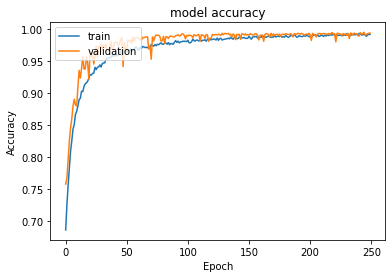

2911/2911 [==============================] - 0s 82us/step
VALIDATION Accuracy =>  [0.04868757793984289, 0.9900377988815308]


In [0]:
# Prints model loss and validation accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print("VALIDATION Accuracy => ", model.evaluate(x_test, y_test))

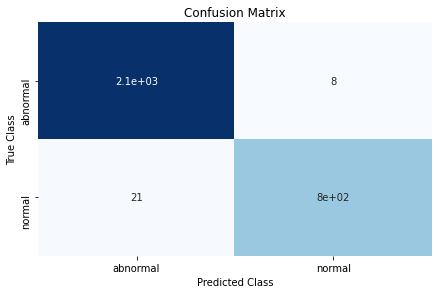


Classification Report
              precision    recall  f1-score   support

    abnormal       0.99      1.00      0.99      2087
      normal       0.99      0.97      0.98       824

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911



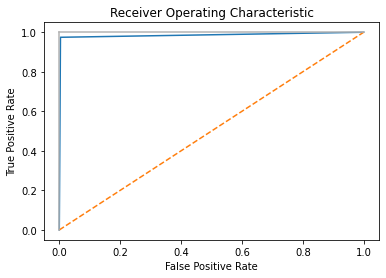

ROCAUC Score =>  0.985340654816455


In [0]:
# PLOTS CONFUSION MATRIX #######################################################
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict([x_test])
ypredb = np.round(y_pred[:,0])
ytestb = np.round(y_test[:,0])

class_names = ['abnormal', 'normal']
cmdf = pd.DataFrame( confusion_matrix(ytestb,ypredb), index=class_names, columns=class_names)

# Create heatmap
sns.heatmap(cmdf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()


# PLOTS CLASSIFICATION REPORT ##################################################
from sklearn.metrics import classification_report
print('\nClassification Report')
print( classification_report(ytestb,ypredb,target_names=['abnormal', 'normal'] )  )


# PLOTS ROCAUC CURVE 3333#######################################################
from sklearn.metrics import roc_curve, roc_auc_score
ypred = np.round(y_pred[:,0])
ytest = np.round(y_test[:,0])

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest,ypred)

# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

print('ROCAUC Score => ', roc_auc_score(ytest,ypred))